# WN stim regen demo
Verifying that stim regen gives correct STA
VR 2025-07-08

In [1]:
import retinanalysis as ra
import numpy as np
import matplotlib.pyplot as plt

[2025-07-08 13:35:15,167][INFO]: Connecting root@127.0.0.1:3306
[2025-07-08 13:35:15,371][INFO]: Connected root@127.0.0.1:3306


In [2]:
df = ra.get_datasets_from_protocol_names('protocols.spatialnoise')
df = df[df.exp_name=='20250514C'].reset_index()
display(df)

idx = 0
exp_name = df.at[idx, 'exp_name']
datafile_name = df.at[idx, 'datafile_name']
pp = ra.create_pipeline(exp_name, datafile_name)


Found 2 protocols matching "protocols.spatialnoise":
['manookinlab.protocols.SpatialNoise'
 'manookinlab.protocols.SpatialNoiseAndMotion']
No epochs found for block 2372

Found 45 experiments, 199 epoch blocks.



,index,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
0,175,20250514C,data000,0.5,chunk1,manookinlab.protocols.SpatialNoise,1,20250514C/data000,Spatial Noise,138,3,2438,3659,499
1,176,20250514C,data001,0.5,chunk1,manookinlab.protocols.SpatialNoise,1,20250514C/data001,Spatial Noise,138,3,2438,3660,499
2,177,20250514C,data006,0.5,chunk2,manookinlab.protocols.SpatialNoise,1,20250514C/data006,Spatial Noise 30 R*,138,3,2443,3665,500
3,178,20250514C,data010,0.5,chunk3,manookinlab.protocols.SpatialNoise,1,20250514C/data010,noise photopic,138,3,2447,3669,506


Nearest noise chunk for data000 is chunk1 with distance 4 minutes.

Loading VCD from /Volumes/Vyom MEA/analysis/20250514C/data000/kilosort2.5 ...
VCD loaded with 769 cells.
Using chunk1 for AnalysisChunk
Loading VCD from /Volumes/Vyom MEA/analysis/20250514C/chunk1/kilosort2.5 ...
VCD loaded with 781 cells.
Loaded spatial maps for channels [0, 2] and 781 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.

Ref clusters matched: 769
Ref clusters unmatched: 12
98.46% matched, 1.54% unmatched.


Let's bin spike times.

In [4]:
pp.response_block.bin_spike_times_by_frames()

Binning spikes for cells: 100%|██████████| 769/769 [00:09<00:00, 82.86it/s] 


Mean frame rate: 59.94 Hz


Let's regenerate WN frames for the first epoch

In [3]:
pp.stim_block.regenerate_stimulus(ls_epochs=[0])

Regenerating stimulus for epochs: [0] in block: data000


100%|██████████| 1/1 [00:34<00:00, 34.61s/it]


Made stimulus of shape: (1, 10819, 127, 203, 3)


In [7]:
import tqdm
def compute_sta(cell_idx, s1: ra.StimBlock, r1: ra.ResponseBlock, n_depth = 15):
    lags = np.arange(0,n_depth)

    sta = np.zeros((len(lags), s1.stim_frames[0].shape[1], s1.stim_frames[0].shape[2]))
    pre_bins = r1.bin_rate * s1.df_epochs.at[0, 'epoch_parameters']['preTime'] * 1e-3
    pre_bins = np.round(pre_bins).astype(int)
    for e_idx in range(len(s1.stim_frames)):
        for i, lag in tqdm.tqdm(list(enumerate(lags)), desc="STA Depth"):
            frames = s1.stim_frames[e_idx, :,:,:, 0]
            bs = r1.df_spike_times.at[cell_idx, 'binned_spikes'][e_idx, pre_bins:pre_bins + len(frames)]
            if lag > 0:
                bs = bs[lag:]
                frames = frames[:-lag]
            # Keep only timepoints with a spike
            mask = np.where(bs > 0)[0]
            if len(mask) == 0:
                print(f'No spikes found for cell idx {cell_idx} in epoch {e_idx}')
                continue
            bs = bs[mask]
            frames = frames[mask]
            frames = np.moveaxis(frames, 0, -1)
            sta[i] += np.matmul(frames, bs)
    return sta

In [8]:
cell_idx = 2
sta = compute_sta(cell_idx, pp.stim_block, pp.response_block)

STA Depth: 100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


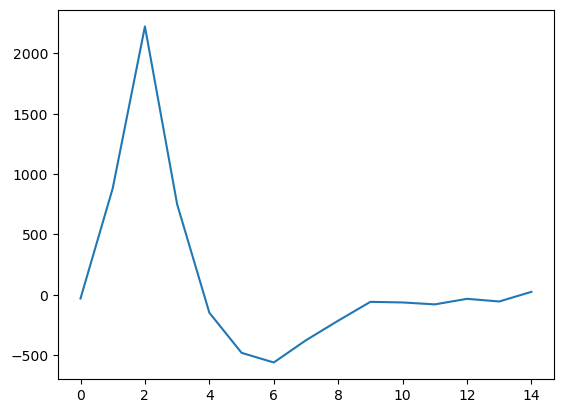

In [13]:
# Get Red channel spatial map, and peak pixel
cell_id = pp.response_block.cell_ids[cell_idx]

sm = pp.analysis_chunk.d_spatial_maps[cell_id][:,:,0]
peak = np.unravel_index(np.argmax(sm), sm.shape)

plt.plot(sta[:,peak[0], peak[1]])

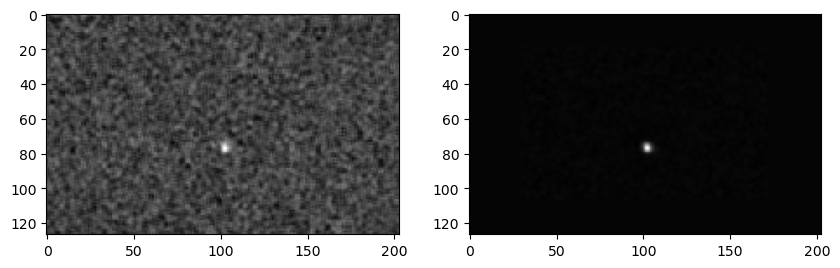

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(sta[3,:,:], cmap='gray')
plt.subplot(122)
plt.imshow(sm, cmap='gray')